In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport new_CCA
%aimport sample_gen
from scipy.stats import multivariate_normal
from collections import defaultdict
%aimport cca_compare

Populating the interactive namespace from numpy and matplotlib


# Creating test distribution

In [2]:
n_bands = 10
n_samples = 1000
d1 = sample_gen.create_distribution(n_bands,mean_std_scale=0.3,std=1)
d2 = sample_gen.create_distribution(n_bands,mean_std_scale=1,std=2,std_scale=0.1)
X = d1.rvs(n_samples)
Y = X+d2.rvs(n_samples)

# Code for testing CCA algorithms

In [3]:
# Generate samples
def gen_samples(sample_size,n_bands=3):
    X = np.random.normal(0,1,size=(sample_size,n_bands))
    Y = X+np.random.normal(0,0.5,size=(sample_size,n_bands))
    return X,Y

# Print info about cca
def cca_info(X,Y, A, B):
    
    prev_u = None
    prev_v = None
    
    for i,(a,b) in enumerate( zip(A.T,B.T) ):
        print('{} cannonical variates pair'.format(i+1))
                
        u = np.dot( X,a )
        v = np.dot( Y,b )

        if prev_u is not None and prev_v is not None:
            print('prev corrcoef:\n{: <10.4f}{: <10.4f}\n{: <10.4f}{: <10.4f}'.format( 
                np.corrcoef(u,prev_u)[0,1], np.corrcoef(u,prev_v)[0,1],
                np.corrcoef(v,prev_u)[0,1], np.corrcoef(v,prev_v)[0,1]
            ))
        prev_u = u
        prev_v = v

        print('corrcoef: {:.4f}'.format(np.corrcoef(u,v)[0,1]))

        # Fit u more tightly to v
        reg = LinearRegression()
        reg.fit(u[:,np.newaxis],v)
        new_u = reg.predict(u[:,np.newaxis])

        plot(new_u[:10],'C0-',label='u')
        plot(u[:10],'C0--')
        plot(v[:10],'C1',label='v')
        legend()
        show()
        
def random_subsample(sample_size,*args):
    ret = []
    ids = np.array([i for i in range(len(args[0]))])
    np.random.shuffle(ids)
    
    for arg in args:
        ret.append(np.array(arg)[ids][:sample_size])
        
    return ret

nastyCorr = None
nastyX = None
nastyY = None

# Compare CCA
def cca_compare(X,Y, funcs_dict, x_samples = 20, n_probas = 10,train_eval=False):
    
    func_labels = list(funcs_dict.keys())
    funcs = [funcs_dict[i] for i in func_labels]
    
    sample_sizes = []
    
    correlations_mean = defaultdict(list)
    correlations_max = defaultdict(list)
    correlations_min = defaultdict(list)
    
    for sample_size in np.linspace(int(X.shape[0]*0.2),X.shape[0],x_samples).astype(np.int):
        sample_sizes.append(sample_size)
        
        for func in funcs:

            corr_pack_mean = []
            corr_pack_max = []
            corr_pack_min = []
            
            for n_proba in range(n_probas):
                corr_pack = []
            
                Xs,Ys = random_subsample(sample_size,X,Y)
                A,B = func(Xs,Ys)
            
                for i,(a,b) in enumerate( zip(A.T,B.T) ):
                    if train_eval:
                        u = np.dot( Xs,a )
                        v = np.dot( Ys,b )
                    else:
                        u = np.dot( X,a )
                        v = np.dot( Y,b )
                    corr_pack.append( np.abs( np.corrcoef(u,v)[0,1] ) )

                global nastyCorr
                if np.array(corr_pack).max() > 0 and (nastyCorr is None or nastyCorr > np.array(corr_pack).max() ):
                    global nastyX
                    global nastyY
                    global nastyCorr
                    nastyX = Xs
                    nastyY = Ys
                    nastyCorr = np.array(corr_pack).max()
                    print("nastyCorr: {}".format(nastyCorr))
                    
                corr_pack_mean.append(corr_pack)

            correlations_min[func].append( np.percentile(corr_pack_mean,1,axis=0) )
            correlations_mean[func].append( np.percentile(corr_pack_mean,50,axis=0) )
            correlations_max[func].append( np.percentile(corr_pack_mean,99,axis=0) )
    
    corr_by_func_min = defaultdict(lambda: defaultdict(list))
    corr_by_func_mean = defaultdict(lambda: defaultdict(list))
    corr_by_func_max = defaultdict(lambda: defaultdict(list))
    
    for func_id,func in enumerate(funcs):
        for component_id, component_corr in enumerate( np.array( correlations_min[func] ).T ):
            corr_by_func_min[component_id][func_id] = component_corr
        for component_id, component_corr in enumerate( np.array( correlations_mean[func] ).T ):
            corr_by_func_mean[component_id][func_id] = component_corr
        for component_id, component_corr in enumerate( np.array( correlations_max[func] ).T ):
            corr_by_func_max[component_id][func_id] = component_corr
        
    for component_id in corr_by_func_mean.keys():
        for func_i,(func,label) in enumerate( zip(funcs,func_labels) ):
            
            if func_i not in corr_by_func_mean[component_id]:
                continue
                
            color = 'C{}'.format(func_i)
            
            min_x  = corr_by_func_min[component_id][func_i]
            mean_x = corr_by_func_mean[component_id][func_i]
            max_x  = corr_by_func_max[component_id][func_i]
            
            plot(sample_sizes, mean_x,color,label=label)
            fill_between(sample_sizes,min_x,max_x,facecolor=color,alpha=0.1)
        
        grid(True)
        title('Comparison of CCA. Band {}'.format(component_id))
        xlabel("sub-Sample size")
        ylabel("Correlation")
        legend()
        show()

<ipython-input-3-f41b1bc6de61>:94: SyntaxWarning: name 'nastyCorr' is used prior to global declaration
  global nastyCorr


# CCA from sklearn

In [4]:
from sklearn.cross_decomposition import CCA
from new_CCA import cca
def sklearn_cca(X,Y,n_components=10):
    cca_instance = CCA(n_components=n_components)
    cca_instance.fit(X,Y)    
    return cca_instance.x_rotations_, cca_instance.y_rotations_

## CCA test fitness

In [7]:
a, b, r = new_CCA.cca(X,Y)
u = np.dot( X,a )
v = np.dot( Y,b )

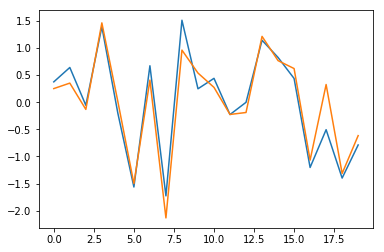

In [8]:
plot(u[:20,0]-u[:20,0].mean())
plot(v[:20,0]-v[:20,0].mean());

In [10]:
from scipy.linalg import sqrtm

# Correlation function
def calc_covariance(xy_sum,x_sum,y_sum,n):
    """
    calculate covariance matrix of 2 variables
    """
    return ( xy_sum - np.matmul(x_sum,y_sum.T)/n )/(n-1)

def calc_linear_regression(n,a,b,x_sum, y_sum, xy_sum, xx_sum ):
    m1 = np.array([[n,(a @ x_sum)[0]],
                  [(a @ x_sum)[0],((a[:,np.newaxis] @ a[:,np.newaxis].T) * xx_sum).sum()]])
    m2 = np.array([
        (b @ y_sum)[0],
        ( ( a[:,np.newaxis] @ b[np.newaxis,:] ) * ( xy_sum ) ).sum()
    ])
    return np.linalg.inv(m1) @ m2

In [112]:
x = X
y = Y

x_sum = np.sum(x,axis=0)[:,np.newaxis]
y_sum = np.sum(y,axis=0)[:,np.newaxis]
xy_sum = np.transpose(x) @ y
xx_sum = np.transpose(x) @ x
yy_sum = np.transpose(y) @ y
n = np.shape(x)[0]

xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)


xx_cov_sqrt_inv = np.linalg.inv( sqrtm(xx_cov) )
yy_cov_sqrt_inv = np.linalg.inv( sqrtm(yy_cov) )

u_mat = xx_cov_sqrt_inv @ xy_cov @ np.linalg.inv(yy_cov) @ xy_cov.T @ xx_cov_sqrt_inv
u_eigvals,u_eigvecs = np.linalg.eig(u_mat)

v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
v_eigvals,v_eigvecs = np.linalg.eig(v_mat)

# Sort eigenvectors by their eigenvalues
# The hypothisis here is that correlation is bigger if eigenvalue of eigenvector is bigger
u = u_eigvecs.T[sorted([i for i in range(len(u_eigvals))], key=lambda x: -u_eigvals[x])]
v = v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

a = (u @ xx_cov_sqrt_inv).T
b = (v @ yy_cov_sqrt_inv).T

regressions = np.array( [ calc_linear_regression(n,a[:,i],b[:,i],x_sum, y_sum, xy_sum, xx_sum ) for i in range(a.shape[1]) ] )
#a = a*regressions[:,1]

u = np.dot( X,a )
v = np.dot( Y,b )

print('first pair corr: {:.2f}'.format(np.corrcoef(u[:,0],v[:,0])[0,1]))

first pair corr: 0.92


# Next steps - calculate Linear Regression on v and u

# Regresion formula:

$$\beta=(U^TU)^{-1}U^TV$$

where $U, V$ - cannonical pair

$$
U^TU = 
\begin{bmatrix}
    n && \sum u_i \\
    \sum u_i && \sum u_i^2
\end{bmatrix}
$$

$$
U^TV = 
\begin{bmatrix}
    \sum v_i \\
    \sum u_i v_i \\
\end{bmatrix}
$$

# IMPORTANT!!!
## Below - formula for u1v1+u2v2+u3v3+...unvn described through xy_sum terms and a,b

This is an essential part for calculating linear regression for target variable v and features u without actually calculating them
This represents term X^{T} y

In [16]:
print( (u[:,0] * v[:,0]).sum() )
print( ( ( a[:,0,np.newaxis] @ b[np.newaxis,:,0] ) * ( xy_sum ) ).sum() )

222809886.067
222809886.067


# Next step - calculate term $u^{T}u$

# Formula for $$\sum_i u_i$$ $$\sum_i v_i$$

In [19]:
print("Original: {}".format(u[:,0].sum()) )
a[:,0] @ x_sum

Original: 233940.17863294523


array([ 233940.17863295])

In [20]:
print("Original: {}".format(v[:,0].sum()))
b[:,0] @ y_sum

Original: 952418.5591125629


array([ 952418.55911256])

# Formula for $\sum_i u^2_i$

In [21]:
print("Original: {}".format( (u[:,0]**2).sum() ) )
((a[:,0,np.newaxis] @ a[:,0,np.newaxis].T) * xx_sum).sum()

Original: 54729006.17881441


54729006.178814434

# Assemble matrices

$$
m1 = U^TU = 
\begin{bmatrix}
    n && \sum u_i \\
    \sum u_i && \sum u_i^2
\end{bmatrix}
$$

$$
m2 = U^TV = 
\begin{bmatrix}
    \sum v_i \\
    \sum u_i v_i \\
\end{bmatrix}
$$

In [48]:
# Ground-truth matrices calculated directly from u and v

m1_true = np.array([
    [u[:,0].shape[0], u[:,0].sum()],
    [u[:,0].sum(), (u[:,0]*u[:,0]).sum()]
])

m2_true = np.array([
    v[:,0].sum(),
    (u[:,0]*v[:,0]).sum(),
])

In [57]:
a[:,0] @ x_sum

array([ 233940.17863295])

In [58]:
a[:,0]

array([ 0.01527299,  0.48296391,  0.01674166, -0.18956444,  0.10117932,
       -0.12335752,  0.00099363, -0.12549717,  0.1336477 ,  0.10949047])

# In other terms

$$
m1 =
\begin{bmatrix}
    n          && a^Tx_{sum} \\
    a^Tx_{sum} && grandsum[ (aa^T) \odot xx_{sum} ]
\end{bmatrix}
$$

$$
m2 =
\begin{bmatrix}
    b^T y_{sum} \\
    grandsum[ (ab^T) \odot xy_{sum} ]
\end{bmatrix}
$$

In [56]:
m1 = np.array([[n,(a[:,0] @ x_sum)[0]],
                  [(a[:,0] @ x_sum)[0],((a[:,0,np.newaxis] @ a[:,0,np.newaxis].T) * xx_sum).sum()]])

m2 = np.array([
    (b[:,0] @ y_sum)[0],
    ( ( a[:,0,np.newaxis] @ b[np.newaxis,:,0] ) * ( xy_sum ) ).sum()
    ])

betas = np.linalg.inv(m1) @ m2
betas

array([ 737.39612153,    0.91913428])

In [55]:
# check correctness
print( 'np.abs(m1-m1_true).max() = {}'.format( np.abs(m1-m1_true).max() ))
print( 'np.abs(m2-m2_true).max() = {}'.format( np.abs(m2-m2_true).max() ))

np.abs(m1-m1_true).max() = 2.2351741790771484e-08
np.abs(m2-m2_true).max() = 2.9802322387695312e-08


# Put calculation of linear regresson into function

In [69]:
def calc_linear_regression(n,a,b,x_sum, y_sum, xy_sum, xx_sum ):
    m1 = np.array([[n,(a @ x_sum)[0]],
                  [(a @ x_sum)[0],((a[:,np.newaxis] @ a[:,np.newaxis].T) * xx_sum).sum()]])
    m2 = np.array([
        (b @ y_sum)[0],
        ( ( a[:,np.newaxis] @ b[np.newaxis,:] ) * ( xy_sum ) ).sum()
    ])
    return np.linalg.inv(m1) @ m2

# Test new code

In [74]:
a,b,r = new_CCA.cca(X,Y)
u = np.dot( X,a )
v = np.dot( Y,b )

In [79]:
np.corrcoef((u+r)[:,1],v[:,1])[0,1]

0.87252536854435581

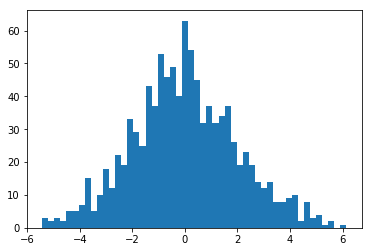

In [104]:
hist( ((u+r)-v).sum(axis=1), bins=50 );

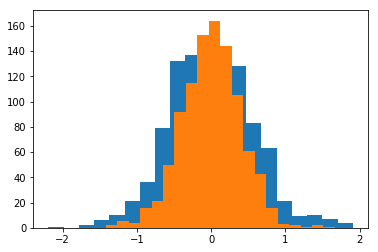

In [96]:
hist( (u+r)[:,3]-v[:,3],bins=20 );
hist( (u+r)[:,0]-v[:,0],bins=20 );

# Dump data to files for testing

In [105]:
import pandas as pd

In [106]:
target_file = "./test_files/"
pd.DataFrame(Y).to_csv("{}test_Y.csv".format(target_file),index=False,header=False)
pd.DataFrame(X).to_csv("{}test_X.csv".format(target_file),index=False,header=False)

pd.DataFrame(xx_cov).to_csv("{}xx_cov.csv".format(target_file),index=False,header=False)
pd.DataFrame(xy_cov).to_csv("{}xy_cov.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_cov).to_csv("{}yy_cov.csv".format(target_file),index=False,header=False)

pd.DataFrame(xx_cov_sqrt_inv).to_csv("{}xx_cov_sqrt_inv.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_cov_sqrt_inv).to_csv("{}yy_cov_sqrt_inv.csv".format(target_file),index=False,header=False)

pd.DataFrame(u).to_csv("{}test_U.csv".format(target_file),index=False,header=False)
pd.DataFrame(v).to_csv("{}test_V.csv".format(target_file),index=False,header=False)

pd.DataFrame(a).to_csv("{}test_a.csv".format(target_file),index=False,header=False)
pd.DataFrame(b).to_csv("{}test_b.csv".format(target_file),index=False,header=False)
pd.DataFrame(x_sum).to_csv("{}x_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(xx_sum).to_csv("{}xx_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(xy_sum).to_csv("{}xy_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_sum).to_csv("{}yy_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(y_sum).to_csv("{}y_sum.csv".format(target_file),index=False,header=False)

# Linear regression

# Below - temporary records

In [94]:
eigenvals,eigenvecs = np.linalg.eig( xx_sum )

E = np.diag( eigenvals )
V = eigenvecs

# E,V
# E - matrix with eigenvalues on diagonal
# V - matrix with eigenvectors

# sqrtMatrix = V * sqrt(E) * V^T

res = V @ sqrt(E) @ V.T

sqrt(E)
sqrtm(xx_cov)

v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
v_eigvals,v_eigvecs = np.linalg.eig(v_mat)

v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

# new shit

In [131]:
b

array([[ 0.01125472,  0.07022403, -0.15452732, -0.10859862,  0.07173875,
         0.01827756, -0.12101278,  0.03240784, -0.34850211,  0.17578212],
       [ 0.45440655,  0.12863645, -0.08495189,  0.30648283,  0.14392713,
        -0.14334599,  0.12605425, -0.00540223, -0.04480623, -0.02748297],
       [ 0.01532313, -0.13543172,  0.11201509, -0.162976  ,  0.36095318,
         0.22431517, -0.10046377,  0.04437409,  0.03086809, -0.08536179],
       [-0.17419422, -0.09943553,  0.01465441,  0.02181472,  0.29879041,
        -0.21475818,  0.17861826,  0.21957805,  0.02537072,  0.21387867],
       [ 0.08083775, -0.26103847, -0.28150439,  0.03005879, -0.13635145,
         0.21186836, -0.02894927,  0.15499045,  0.0721202 ,  0.12553757],
       [-0.11217864,  0.13737401, -0.01056573, -0.01328549,  0.00129932,
         0.24957152,  0.31447598, -0.08308119, -0.06371959, -0.03538374],
       [ 0.0009251 ,  0.40247681, -0.05614413, -0.11982895,  0.05009319,
         0.12957027, -0.12815398,  0.15929782